In [67]:
!pip install nltk
import nltk
nltk.download('wordnet')


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.9/773.9 KB 7.5 MB/s eta 0:00:00m eta 0:00:010:01


[nltk_data] Downloading package wordnet to /home/jen/nltk_data...


True

/home/jen/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jen/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


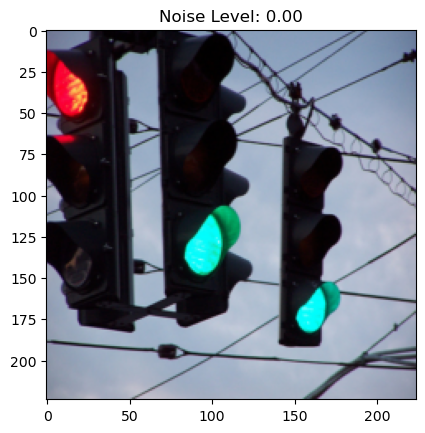

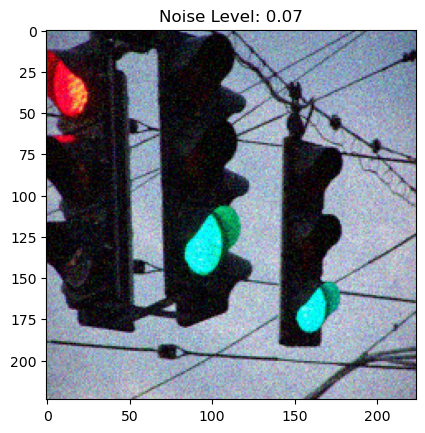

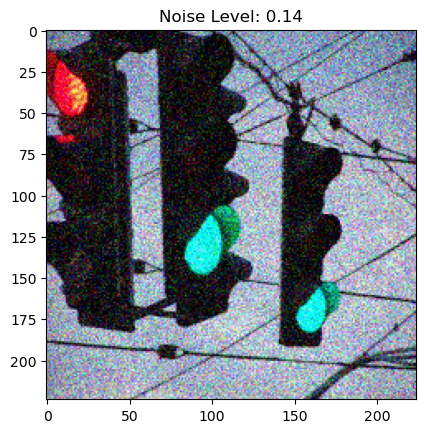

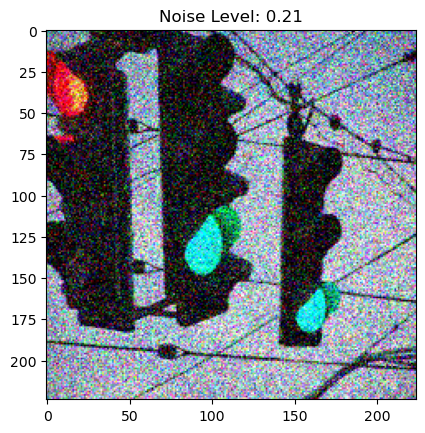

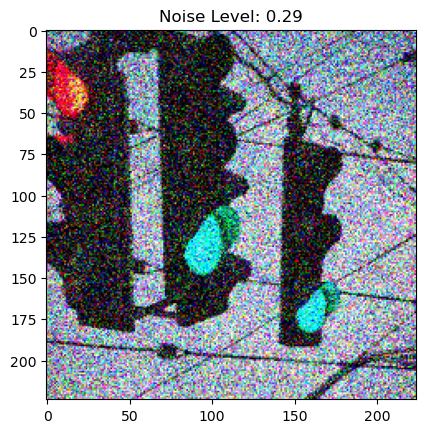

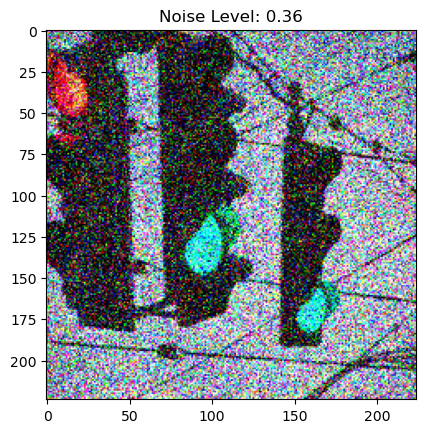

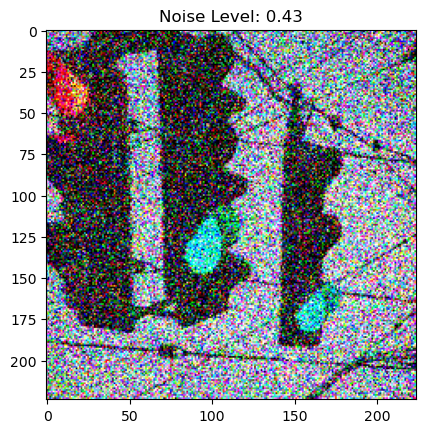

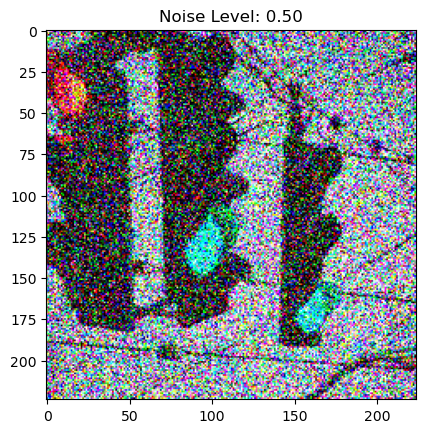

Average accuracy for noise level 0.00: 1.0
Average accuracy for noise level 0.07: 1.0
Average accuracy for noise level 0.14: 1.0
Average accuracy for noise level 0.21: 1.0
Average accuracy for noise level 0.29: 1.0
Average accuracy for noise level 0.36: 0.67
Average accuracy for noise level 0.43: 0.07
Average accuracy for noise level 0.50: 0.0


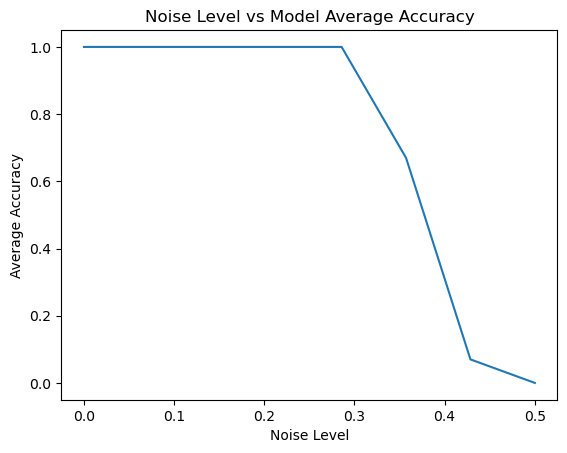

In [77]:
import os
import random
from PIL import Image
import torch
import numpy as np
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from nltk.corpus import wordnet as wn

def get_broader_category(label):
    # Find synsets for the given label
    synsets = wn.synsets(label)

    # If synsets are found, try to find a broader category
    if synsets:
        # Get hypernyms (broader categories) of the first synset
        # You might need to adjust this logic depending on how specific you want the categories to be
        hypernyms = synsets[0].hypernyms()
        if hypernyms:
            return hypernyms[0].lemma_names()[0]  # Return the name of the first hypernym

    return label  # Return the original label if no broader category is found


    
# Function to load a random ImageNet image
def load_random_imagenet_image(imagenet_path):
    subdirs = [d for d in os.listdir(imagenet_path) if os.path.isdir(os.path.join(imagenet_path, d))]
    random_subdir = random.choice(subdirs)
    subdir_path = os.path.join(imagenet_path, random_subdir)
    images = [img for img in os.listdir(subdir_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random_image = random.choice(images)
    image_path = os.path.join(subdir_path, random_image)
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    image = transform(image)
    return image, random_subdir

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0., std=0.001):
    noise = torch.randn(image.size()) * std + mean
    noisy_image = torch.clamp(image + noise, 0, 1)
    return noisy_image

def display_noisy_image(image, noise_std, title=None):
    """Function to display a noisy image"""
    noisy_image = add_gaussian_noise(image, std=noise_std)
    image = to_pil_image(noisy_image)  # Convert tensor to PIL Image
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

# Function to predict with ResNet50
def predict_with_resnet50(model, image):
    if len(image.size()) == 3:
        image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
        _, predicted_idx = torch.max(outputs, 1)
    return predicted_idx.item()

# Parse synset mapping file
def parse_synset_mapping(file_path):
    synset_to_label = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                synset_id, label = parts
                synset_to_label[synset_id] = label
    return synset_to_label

# Paths to ImageNet dataset and synset mapping file
imagenet_path = '/media/jen/T7/ImageNet/ImageNet Data/ILSVRC/Data/CLS-LOC/train'
synset_file_path = '/media/jen/T7/ImageNet/ImageNet Data/LOC_synset_mapping.txt'
synset_to_label = parse_synset_mapping(synset_file_path)
imagenet_dataset = datasets.ImageFolder(root=imagenet_path, transform=transforms.ToTensor())

def predict_with_resnet50(model, image, dataset):
    if len(image.size()) == 3:
        image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
        _, predicted_idx = torch.max(outputs, 1)
    predicted_synset = dataset.classes[predicted_idx.item()]
    return synset_to_label.get(predicted_synset, "Unknown")

# Load a random ImageNet image
random_image, true_label_synset = load_random_imagenet_image(imagenet_path)
true_label = synset_to_label[true_label_synset]

# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()


def imshow(tensor, title=None):
    image = to_pil_image(tensor)  # Convert tensor to PIL Image
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()
    

# Modified noise levels from 0.1 to 0.8
noise_levels = np.linspace(0, 0.5, 8)
accuracies = []

for noise_level in noise_levels:
    display_noisy_image(random_image, noise_level, title=f"Noise Level: {noise_level:.2f}")

for std_dev in noise_levels:
    accuracy_sum = 0

    for _ in range(100):
        noisy_image = add_gaussian_noise(random_image, std=std_dev)
        predicted_label = predict_with_resnet50(model, noisy_image, imagenet_dataset)

        # Map both predicted and true labels to their broader categories
        predicted_broader = get_broader_category(predicted_label)
        true_broader = get_broader_category(true_label)

        # Check if the broader categories match
        accuracy = int(predicted_broader == true_broader)
        accuracy_sum += accuracy

    average_accuracy = accuracy_sum / 100
    accuracies.append(average_accuracy)

    print(f"Average accuracy for noise level {std_dev:.2f}: {average_accuracy}")


# Plotting noise level vs average accuracy
plt.plot(noise_levels, accuracies)
plt.xlabel('Noise Level')
plt.ylabel('Average Accuracy')
plt.title('Noise Level vs Model Average Accuracy')
plt.show()


In [70]:
print(noise_levels)
print(accuracies)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[0.59, 0.3, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0]
